In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [53]:
data = pd.read_excel("estimate_power_consumption_total.xlsx")
data.head()

,unit_no,maxa,maxr,active,reactive,consumption
0,1,1322.0,1043.0,26815.0,568.0,264.452105
1,2,1316.0,1032.0,24773.0,253.0,39.563698
2,4,1345.0,1005.0,26820.0,112.0,191.193007
3,6,1336.0,1013.0,25470.0,150.0,185.514004
4,1,1320.0,1038.0,26875.0,636.0,216.559192


In [54]:
data.isnull().sum()

unit_no        0
maxa           0
maxr           0
active         0
reactive       0
consumption    0
dtype: int64

In [55]:
X = data[["unit_no","maxa","maxr","active","reactive"]]
y = data[["consumption"]]
y

,consumption
0,264.452105
1,39.563698
2,191.193007
3,185.514004
4,216.559192
...,...
42319,287.735996
42320,229.053007
42321,2397.376644
42322,2413.639269


In [56]:
X

,unit_no,maxa,maxr,active,reactive
0,1,1322.0,1043.0,26815.0,568.000000
1,2,1316.0,1032.0,24773.0,253.000000
2,4,1345.0,1005.0,26820.0,112.000000
3,6,1336.0,1013.0,25470.0,150.000000
4,1,1320.0,1038.0,26875.0,636.000000
...,...,...,...,...,...
42319,5,1319.0,1017.0,26645.0,445.000000
42320,6,1319.0,1020.0,26810.0,485.000000
42321,7,1336.0,1037.0,27120.0,895.799988
42322,8,1332.0,1034.0,27010.0,811.599976


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [58]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

In [59]:
# Training the Decision Tree Regression model on the whole dataset
nn = MLPRegressor()
nn.fit(X_train, y_train)
y_pred=nn.predict(X_test)

In [60]:
mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("Mean squared error:",mse)
print("R-squared:",r2)

Mean squared error: 330523.22686261305
R-squared: 0.4296904732294554


# Tuning the hyperparameters

In [61]:
# Define the SVR model
nn = MLPRegressor()

# Define the hyperparameters to tune
param_grid = {'hidden_layer_sizes': [(10,), (20,), (30,), (40,)],
              'activation': ['relu', 'tanh', 'logistic'],
              'alpha': [0.0001, 0.001, 0.01, 0.1]}
# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(nn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (40,)}
Best score: 0.6769845528229197


In [62]:
regressor = MLPRegressor(**grid_search.best_params_)
regressor.fit(X_train, y_train)
y_pred=regressor.predict(X_test)

In [63]:
mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("Mean squared error:",mse)
print("R-squared:",r2)

Mean squared error: 265093.26135899604
R-squared: 0.5753238597208082


# Trying dimention reduction for the model

In [64]:
# Apply PCA to reduce the number of features to 3
pca = PCA(n_components=X.shape[1])
X_train_pca = pca.fit_transform(X_train)

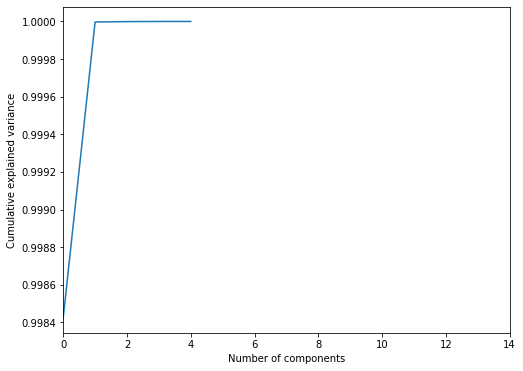

In [65]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,14,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

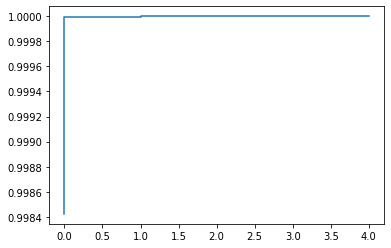

In [66]:
cumulative=np.cumsum(pca.explained_variance_ratio_)
plt.step([i for i in range(len(cumulative))],cumulative)
plt.show()

In [67]:
pca=PCA().fit(X_train)
print(pca.explained_variance_ratio_)
print()


[9.98423453e-01 1.57373970e-03 2.03599218e-06 7.42691000e-07
 2.86058653e-08]



In [68]:
pipeline = Pipeline([
    ('pca', PCA(n_components=X.shape[1])),
    ('nn', MLPRegressor(**grid_search.best_params_))
])

In [69]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [70]:
# Calculate Mean Squared Error (MSE) of the predictions 
mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("Mean squared error:",mse)
print("R-squared:",r2)

Mean squared error: 123894.14751033712
R-squared: 0.8457838755265292
